--- Generating Graph Series ---
Sizes: [20, 40, 60, 80, 100]
Connectivity: 0.15, Busy Node Interval: 6

Creating graph size: 20 (seed=62)...
  Graph created: 20 nodes, 27 edges.

Creating graph size: 40 (seed=82)...
  Graph created: 40 nodes, 105 edges.

Creating graph size: 60 (seed=102)...
  Graph created: 60 nodes, 247 edges.

Creating graph size: 80 (seed=122)...
  Graph created: 80 nodes, 477 edges.

Creating graph size: 100 (seed=142)...
  Graph created: 100 nodes, 731 edges.

--- Graph Generation Complete ---

--- Starting Hierarchical QL Benchmarking Across Sizes ---

=============== Processing Graph Size: 20 ===============
Initializing Hierarchical Q-Learning agent (target k=3) for size 20...
Partitioning graph (Nodes: 20) into target k=3 regions...
Actual regions created: 3. Border nodes: 7

--- Starting Hierarchical QL Training (Size: 20, Regions: 3, Episodes: 30000) ---
  Ep 1500/30000 | Avg R(100): 28.84 | Avg S(100): 13.7 | Success Rate(100): 100.0% | Eps: 0.741
  Ep 300

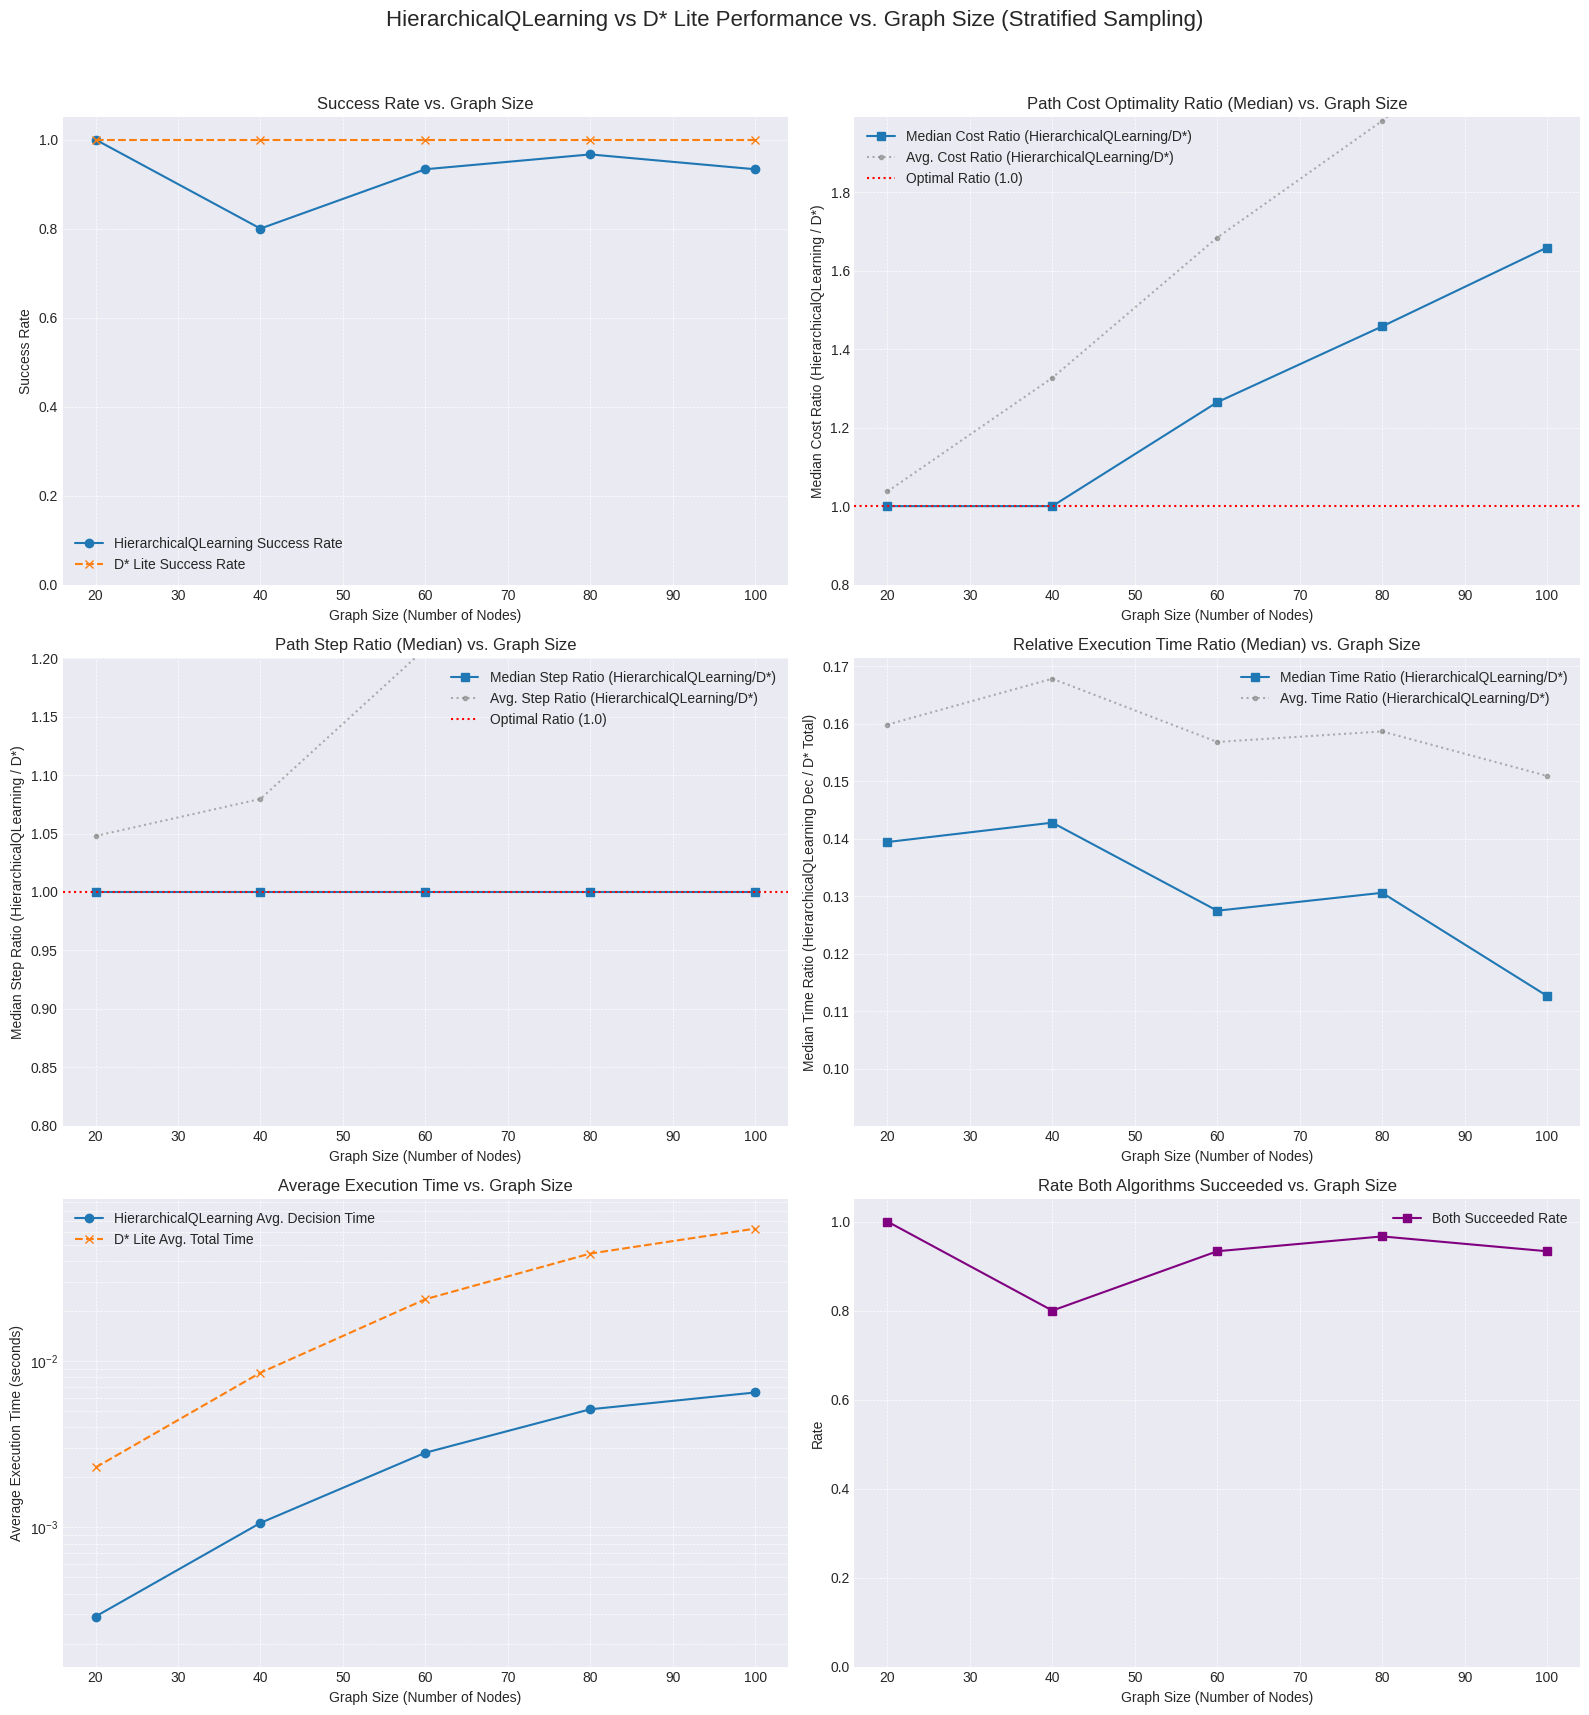


--- Experiment Finished ---


In [2]:
# --- Imports ---
import networkx as nx
import numpy as np # Needed for percentile calculation
import random
import matplotlib.pyplot as plt
import math
import time
import heapq
from collections import defaultdict, deque
import copy
import json # For potentially saving results

# --- Graph Creation & Utilities (Keep as before) ---
# ... (create_dynamic_graph, update_edge_weights, reset_graph_weights) ...
# --- Modified Graph Creation with Scalable Index Pattern ---
def create_dynamic_graph(num_nodes=20, seed=42, connectivity=0.3,
                         busy_node_pattern_interval=5):
    """
    Creates a deterministic random graph with time-varying edge weights,
    assigns node positions, and selects busy nodes based on a consistent
    index interval pattern to ensure scalable distribution.
    """
    if num_nodes <= 0:
        print("Warning: num_nodes must be positive. Returning empty graph.")
        return nx.Graph()

    # Set seeds for reproducibility FOR THIS SPECIFIC GRAPH SIZE
    random.seed(seed)
    np.random.seed(seed)

    # Create a random graph (undirected)
    G = nx.erdos_renyi_graph(n=num_nodes, p=connectivity, seed=seed)

    # --- Ensure Connectivity ---
    max_attempts = num_nodes * 2
    attempts = 0
    # Only try to connect if there's more than one node
    if G.number_of_nodes() > 1:
        while not nx.is_connected(G) and attempts < max_attempts :
            components = list(nx.connected_components(G))
            if len(components) > 1:
                # Connect a random node from a smaller component to the largest one
                largest_component = max(components, key=len)
                other_components = [c for c in components if c != largest_component]
                # Choose a random component that is not the largest
                if not other_components: # Should not happen if len(components)>1, but safety check
                    break
                comp_to_connect = random.choice(other_components)

                u = random.choice(list(largest_component))
                v = random.choice(list(comp_to_connect))
                # Avoid self-loops if components somehow overlap (shouldn't happen)
                if u != v:
                    G.add_edge(u, v)
                else: # Try different nodes if the chosen ones were identical
                    u_alt = random.choice(list(largest_component))
                    v_alt = random.choice(list(comp_to_connect))
                    if u_alt != v_alt: G.add_edge(u_alt, v_alt)
            else: # Graph has edges but somehow len(components) <= 1 (should be connected)
                 break
            attempts += 1

        if attempts >= max_attempts and not nx.is_connected(G) and G.number_of_nodes() > 1:
             # Last resort: Connect remaining components more directly if possible
             components = list(nx.connected_components(G))
             if len(components) > 1:
                 first_node_comp1 = next(iter(components[0])) # Get a node from first component
                 for i in range(1, len(components)):
                     node_from_other_comp = next(iter(components[i]))
                     if not G.has_edge(first_node_comp1, node_from_other_comp):
                         G.add_edge(first_node_comp1, node_from_other_comp)
                         # print(f"  Force connect {first_node_comp1} and {node_from_other_comp}") # Debug
                 if not nx.is_connected(G):
                    print(f"Warning: Could not ensure graph connectivity for size {num_nodes} after {max_attempts}+{len(components)-1} attempts.")

    # --- Define busy nodes using the scalable index pattern ---
    busy_nodes = []
    if num_nodes > 0 and busy_node_pattern_interval > 0:
        # Select nodes where index modulo interval is 0
        busy_nodes = [i for i in range(num_nodes) if i % busy_node_pattern_interval == 0]
    elif num_nodes > 0:
        print(f"Warning: Invalid busy_node_pattern_interval ({busy_node_pattern_interval}). No busy nodes selected.")

    # --- Assign initial edge weights and dynamic parameters ---
    for u, v in G.edges():
        is_busy_edge = (u in busy_nodes) or (v in busy_nodes)
        # Consistent weight distribution logic
        base_weight = random.uniform(7.0, 10.0) if is_busy_edge else random.uniform(1.0, 4.0)

        G[u][v]['weight'] = base_weight
        G[u][v]['base_weight'] = base_weight
        G[u][v]['variation'] = random.uniform(0.5, 2.5) # Consistent dynamic range
        G[u][v]['period'] = random.uniform(0.05, 0.3)   # Consistent dynamic speed

    # --- Assign node positions ---
    try:
        if G.number_of_nodes() > 50: # Use a potentially faster/better layout for large graphs
            G.pos = nx.kamada_kawai_layout(G)
        elif G.number_of_nodes() > 0:
            G.pos = nx.spring_layout(G, seed=seed) # Spring layout for smaller graphs
        else:
            G.pos = {} # Empty dict for empty graph
    except Exception as e: # Catch any layout error
         print(f"Warning: Layout algorithm failed for size {num_nodes} (seed={seed}, error={e}). Using random layout.")
         G.pos = nx.random_layout(G, seed=seed) if G.nodes else {}

    # Ensure pos attribute exists
    if not hasattr(G, 'pos'):
         G.pos = nx.random_layout(G, seed=seed) if G.nodes else {}

    return G

# --- Graph Utilities ---
def update_edge_weights(G, time_step):
    """Updates edge weights based on time step."""
    if not G or not G.edges: return G
    for u, v in G.edges():
        base = G[u][v].get('base_weight', 5.0)
        variation = G[u][v].get('variation', 1.0)
        period = G[u][v].get('period', 0.2)
        try:
            factor = np.sin(time_step * period) * variation
            G[u][v]['weight'] = max(0.1, base + factor) # Ensure weights remain positive
        except Exception: G[u][v]['weight'] = base # Fallback to base weight on error
    return G

def reset_graph_weights(G):
    """Resets edge weights to base values."""
    if not G or not G.edges: return G
    for u, v in G.edges():
        base_weight = G[u][v].get('base_weight')
        if base_weight is not None:
            G[u][v]['weight'] = base_weight
        else:
             # Fallback if base_weight is missing for some reason
             G[u][v]['weight'] = random.uniform(1, 10)
             G[u][v]['base_weight'] = G[u][v]['weight']
    return G


# --- D* Lite Implementation (Keep as before) ---
# ... (class DStarLite, navigate_with_dstar) ...
class DStarLite:
    # --- D* Lite Code (Exactly as in the previous corrected version) ---
    def __init__(self, graph, start, goal):
        self.G = graph # Should be a NetworkX Graph (undirected assumed)
        self.start = start
        self.goal = goal
        self.current = start # Agent's current position

        self.U = [] # Priority queue (min-heap)
        self.g = defaultdict(lambda: float('inf'))
        self.rhs = defaultdict(lambda: float('inf'))
        self.km = 0 # Key modifier for heuristic updates

        self.rhs[goal] = 0
        try:
            initial_key = self.calculate_key(goal)
            if not isinstance(initial_key, tuple) or len(initial_key) != 2:
                raise TypeError(f"Initial key for goal {goal} is not a valid tuple: {initial_key}")
            heapq.heappush(self.U, (initial_key, goal))
        except TypeError as e:
             print(f"Error pushing initial goal node {goal} to heap: {e}")
             print(f"Goal key calculation resulted in: {self.calculate_key(goal)}")
             # Depending on severity, maybe raise it, or try to continue carefully
             raise # Re-raise the exception

    def calculate_key(self, node):
        """Calculate the key for a node in the priority queue"""
        g_val = self.g[node]
        rhs_val = self.rhs[node]
        min_g_rhs = min(g_val, rhs_val)

        h_cost = self.heuristic(self.start, node)
        # Ensure heuristic is a number, default to 0 if not
        if not isinstance(h_cost, (int, float)) or math.isnan(h_cost) or math.isinf(h_cost):
            h_cost = 0

        # Ensure min_g_rhs is a number, default to infinity if not (should be inf or a number)
        if not isinstance(min_g_rhs, (int, float)) or math.isnan(min_g_rhs):
            min_g_rhs = float('inf') # Treat as unreachable

        # Key calculation, handle potential infinities
        key1 = float('inf')
        if min_g_rhs != float('inf'):
             key1 = min_g_rhs + h_cost + self.km
        key2 = min_g_rhs

        # Check for NaN or Inf results in keys before returning
        if math.isnan(key1) or math.isnan(key2) or math.isinf(key1) or math.isinf(key2):
           # If calculation leads to invalid numbers, return a maximal key to deprioritize
           # print(f"Warning: Invalid key calculation for node {node}. g={g_val}, rhs={rhs_val}, h={h_cost}, km={self.km}")
           return (float('inf'), float('inf'))

        return (key1, key2)

    def heuristic(self, a, b):
        """Heuristic function (Euclidean distance if positions exist)"""
        # Check if nodes exist in the graph and have positions
        if a not in self.G or b not in self.G: return 0
        if not hasattr(self.G, 'pos') or not self.G.pos: return 0 # No position attribute
        if a not in self.G.pos or b not in self.G.pos: return 0 # Nodes missing positions

        pos_a, pos_b = self.G.pos[a], self.G.pos[b]

        # Validate position data format and content
        if (isinstance(pos_a, (list, tuple)) and len(pos_a) >= 2 and
            isinstance(pos_b, (list, tuple)) and len(pos_b) >= 2 and
            all(isinstance(coord, (int, float)) and not math.isnan(coord) and not math.isinf(coord) for coord in pos_a[:2] + pos_b[:2])):
             try:
                 dist = math.sqrt((pos_a[0] - pos_b[0])**2 + (pos_a[1] - pos_b[1])**2)
                 # Return distance only if it's a valid number
                 return dist if not math.isnan(dist) and not math.isinf(dist) else 0
             except (TypeError, ValueError):
                 # Error during calculation (e.g., non-numeric values despite check)
                 return 0
        else:
            # Invalid position data format or content
            # print(f"Warning: Invalid position data for heuristic calculation between {a} and {b}. Pos A: {pos_a}, Pos B: {pos_b}")
            return 0


    def update_vertex(self, u):
        """Update the RHS value and priority queue entry for a vertex"""
        if u != self.goal:
            min_rhs = float('inf')
            try:
                # Iterate over neighbors, ensuring they exist in the graph
                neighbors_of_u = list(self.G.neighbors(u)) if u in self.G else []
                for v in neighbors_of_u:
                    cost = self.get_edge_cost(u, v)
                    g_v = self.g[v]
                    # Check if cost and g[v] are finite before calculating sum
                    if cost != float('inf') and g_v != float('inf'):
                        min_rhs = min(min_rhs, cost + g_v)
            except Exception as e:
                 print(f"Error finding neighbors or costs during update_vertex for {u}: {e}")
                 # Keep min_rhs as infinity if errors occur
                 min_rhs = float('inf')
            self.rhs[u] = min_rhs

        # Efficiently remove if exists
        # Use a more direct check if the heap allows (or rebuild as before)
        node_in_queue = any(node == u for _, node in self.U)
        if node_in_queue:
             # Simple O(N) removal and O(N log N) heapify
             self.U = [(key, node) for key, node in self.U if node != u]
             heapq.heapify(self.U)


        if self.g[u] != self.rhs[u]:
            try:
                 key_u = self.calculate_key(u)
                 # Double-check key validity before pushing
                 if not isinstance(key_u, tuple) or len(key_u) != 2 or \
                    any(math.isnan(k) or math.isinf(k) for k in key_u):
                    raise TypeError(f"Invalid key calculated for node {u}: {key_u}")
                 heapq.heappush(self.U, (key_u, u))
            except TypeError as e:
                 print(f"Error pushing node {u} during update: {e}")
                 # Decide how to handle: skip update? raise further? For now, just print.

    def get_edge_cost(self, u, v):
         """Safely get edge cost, returning infinity for non-existent edges or invalid weights."""
         if not self.G.has_node(u) or not self.G.has_node(v):
              return float('inf') # Nodes must exist
         if self.G.has_edge(u, v):
             edge_data = self.G[u][v]
             weight = edge_data.get('weight', float('inf'))
             # Ensure weight is a valid positive number, otherwise treat as impassable
             if isinstance(weight, (int, float)) and not math.isnan(weight) and not math.isinf(weight) and weight >= 0:
                 return weight
             else:
                 # print(f"Warning: Invalid edge weight ({weight}) for edge ({u},{v}). Treating as inf.")
                 return float('inf')
         else:
              return float('inf') # No edge exists


    def compute_shortest_path(self):
        """Compute shortest path values, propagating cost updates."""
        max_compute_steps = self.G.number_of_nodes() * self.G.number_of_nodes() * 2 # Heuristic limit
        compute_steps = 0

        while self.U: # Check if heap is not empty first
            # Safely peek top key and calculate start key
            try:
                top_key = self.U[0][0]
                start_key = self.calculate_key(self.start)
            except IndexError: # Heap became empty
                break
            except Exception as e: # Error calculating keys
                 print(f"Error calculating keys during D* loop check: {e}")
                 break # Stop computation if keys are problematic

            # Loop Condition: top key < start key OR start node is inconsistent
            if not (top_key < start_key or self.rhs[self.start] != self.g[self.start]):
                break # Path to start is consistent and optimal relative to queue

            compute_steps += 1
            if compute_steps > max_compute_steps:
                 print(f"Warning: Exceeded D* compute step limit ({max_compute_steps}) for start={self.start}, goal={self.goal}. Pathfinding may fail or be suboptimal.")
                 break # Prevent potential infinite loops

            try:
                k_old, u = heapq.heappop(self.U)
            except IndexError:
                # print(f"Warning: D* Queue empty unexpectedly during compute_shortest_path (start={self.start}, goal={self.goal}).")
                break

            # Check if popped node 'u' is valid
            if u not in self.G: continue # Skip if node somehow doesn't exist

            k_new = self.calculate_key(u)

            # --- Key Comparison ---
            # Note: Comparing tuples directly: (1, 2) < (1, 3) is True, (2, 1) < (1, 5) is False
            if k_old < k_new:
                # Key increased: Path through u potentially worsened. Re-insert with new key.
                try:
                     # Check key validity again before pushing
                     if not isinstance(k_new, tuple) or len(k_new) != 2 or any(math.isnan(k) or math.isinf(k) for k in k_new):
                         raise TypeError(f"Invalid new key {k_new}")
                     heapq.heappush(self.U, (k_new, u))
                except TypeError as e:
                    print(f"Error pushing node {u} (key increased) back to heap: {e}")

            # --- Consistency Check ---
            elif self.g[u] > self.rhs[u]:
                # Overconsistent (g > rhs): Found a potentially shorter path to u. Update g(u).
                self.g[u] = self.rhs[u]
                # Propagate change to neighbors
                try:
                     neighbors_of_u = list(self.G.neighbors(u)) if u in self.G else []
                     for s in neighbors_of_u:
                         self.update_vertex(s)
                except Exception as e:
                      print(f"Error updating neighbors of {u} (overconsistent case): {e}")

            else:
                # Underconsistent (g < rhs implicitly, as g!=rhs handled by update_vertex push):
                # The previous path supporting g(u) is no longer valid/optimal.
                g_old = self.g[u] # Store old value (optional)
                self.g[u] = float('inf') # Set g to infinity
                # Update u itself and its neighbors, as their paths might depend on the old g(u).
                try:
                    affected_nodes = [u] # Start with u
                    if u in self.G:
                         affected_nodes.extend(list(self.G.neighbors(u)))

                    for s in affected_nodes:
                         # Ensure node s still exists before updating
                         if s in self.G:
                              self.update_vertex(s)
                except Exception as e:
                     print(f"Error updating neighbors/self of {u} (underconsistent case): {e}")

            # --- Safety Checks (Optional but good practice) ---
            # Check queue size
            if len(self.U) > self.G.number_of_nodes() * 10: # Arbitrary large factor
                 print(f"Warning: D* queue size potentially excessive ({len(self.U)} nodes for graph size {self.G.number_of_nodes()}). May indicate issues.")
                 # Consider breaking if it grows uncontrollably

            # Check for non-numeric g/rhs values periodically (debugging)
            # if compute_steps % 100 == 0: # Check every 100 steps
            #      problematic_g = {n: val for n, val in self.g.items() if not isinstance(val, (int, float)) or math.isnan(val)}
            #      problematic_rhs = {n: val for n, val in self.rhs.items() if not isinstance(val, (int, float)) or math.isnan(val)}
            #      if problematic_g or problematic_rhs:
            #          print(f"Warning: Non-numeric g/rhs values detected at step {compute_steps}. Problem g: {problematic_g}, Problem rhs: {problematic_rhs}")


    def get_next_node(self):
        """Get the best next node to move to from the current position."""
        if self.current == self.goal:
            return None # Already at the goal

        min_cost_plus_g = float('inf')
        best_next_node = None

        # Ensure current node exists and get neighbors safely
        if self.current not in self.G:
             print(f"Error: Current node {self.current} not found in graph during get_next_node.")
             return None
        try:
            neighbors = list(self.G.neighbors(self.current))
        except Exception as e:
             print(f"Error getting neighbors for {self.current}: {e}")
             return None

        if not neighbors:
            # print(f"Warning: Node {self.current} has no neighbors.") # Agent is stuck
            return None

        candidate_nodes = [] # Store (cost+g, heuristic, node) for tie-breaking

        for neighbor in neighbors:
            # Ensure neighbor exists before getting cost/g-value
            if neighbor not in self.G: continue

            cost = self.get_edge_cost(self.current, neighbor)
            g_neighbor = self.g[neighbor]

            # Skip if edge is impassable or neighbor is currently unreachable
            if cost == float('inf') or g_neighbor == float('inf'):
                continue

            # Calculate the total estimated cost: cost_to_neighbor + g_value(neighbor)
            current_total_cost = cost + g_neighbor

            # Calculate heuristic from neighbor to goal for tie-breaking
            h_neighbor = self.heuristic(neighbor, self.goal)
            # Ensure heuristic is valid
            if not isinstance(h_neighbor, (int, float)) or math.isnan(h_neighbor) or math.isinf(h_neighbor):
                h_neighbor = float('inf') # Penalize invalid heuristics in tie-breaking

            candidate_nodes.append((current_total_cost, h_neighbor, neighbor))

        # If no valid neighbors were found
        if not candidate_nodes:
            return None

        # Sort candidates:
        # 1. Primary key: lowest total cost (cost + g)
        # 2. Secondary key: lowest heuristic cost from neighbor to goal
        # 3. Tertiary key: lowest node index (arbitrary but deterministic)
        candidate_nodes.sort(key=lambda x: (x[0], x[1], x[2]))

        # The best node is the first one after sorting
        best_next_node = candidate_nodes[0][2]

        return best_next_node

    def move_to(self, node):
        """Update the agent's current position and the 'start' reference for planning."""
        if node is not None and node != self.current:
            # Optional: Store the previous start position if needed for km update
            # last_start_pos_before_move = self.start

            self.current = node
            # Update the 'start' node for future planning calculations from the new position
            self.start = node

            # Optional: Update km (key modifier) - More complex D* Lite versions use this.
            # This example keeps km=0, simplifying the key calculation slightly.
            # If implementing km updates, it often involves the heuristic change:
            # self.km += self.heuristic(last_start_pos_before_move, self.start)

    def notify_edge_changes(self, changed_edges_nodes=None):
        """
        Notify D* about potential edge changes and trigger replanning.
        Assumes the graph self.G has already been updated externally.
        'changed_edges_nodes' is an optional set/list of nodes connected
        to edges that might have changed. If None, check all nodes.
        """
        nodes_to_update = set()

        if changed_edges_nodes:
            # If specific nodes are provided, update them and potentially their neighbors
            for node in changed_edges_nodes:
                if node in self.G: # Ensure node still exists
                    nodes_to_update.add(node)
                    # Consider adding neighbors too for robustness, though direct update often suffices
                    # try:
                    #    for neighbor in self.G.neighbors(node):
                    #        if neighbor in self.G: nodes_to_update.add(neighbor)
                    # except Exception: pass # Ignore errors getting neighbors here
        else:
            # If no specific nodes provided, assume any edge could change.
            # Re-check all nodes involved in edges. Safer but potentially slower.
            if self.G and self.G.edges:
                for u, v in self.G.edges():
                    if u in self.G: nodes_to_update.add(u)
                    if v in self.G: nodes_to_update.add(v)
            else: # No edges, nothing to update based on edges
                 return # Exit early


        # Update the potentially affected vertices.
        # This recalculates their rhs based on current neighbors' g-values and new edge costs.
        # If a node becomes inconsistent (g != rhs), update_vertex handles the priority queue.
        # print(f"D* Lite: Notified of changes. Updating {len(nodes_to_update)} potentially affected nodes.") # Debug
        if nodes_to_update:
            for node in nodes_to_update:
                if node in self.G: # Final check before update
                    self.update_vertex(node)

            # After queueing inconsistent nodes, recompute shortest path to propagate updates.
            try:
                self.compute_shortest_path()
            except Exception as e:
                 print(f"Error during D* re-computation after edge changes: {e}")
                 # Handle error: maybe clear queue, maybe raise?
                 self.U = [] # Clear queue as state might be corrupted
                 raise # Re-raise to signal failure


# --- D* Lite Navigation Function ---
# <<< navigate_with_dstar function >>>
def navigate_with_dstar(graph_instance, start_node, goal_node, max_steps=None):
    """Navigate using D* Lite, handling dynamic weights during navigation."""
    # print(f"\n--- D* Lite Nav: {start_node} -> {goal_node} (Size: {graph_instance.number_of_nodes()}) ---")
    G_nav = graph_instance # Use the graph directly
    if start_node not in G_nav or goal_node not in G_nav:
        print(f"Error: Start ({start_node}) or Goal ({goal_node}) node not in graph nodes {list(G_nav.nodes())}.")
        return [], float('inf'), 0, 0.0

    # Ensure start and goal are different
    if start_node == goal_node:
        print("Start and goal nodes are the same.")
        return [start_node], 0.0, 0, 0.0

    # Reset weights to base values before starting navigation
    reset_graph_weights(G_nav)

    try:
        # Initialize D* Lite planner
        planner = DStarLite(G_nav, start_node, goal_node)
    except Exception as e:
        print(f"Error initializing D* Lite planner: {e}")
        import traceback
        traceback.print_exc()
        return [], float('inf'), 0, 0.0

    current_node = start_node
    current_time_step = 0 # Tracks time steps for dynamic weight updates
    total_cost = 0.0
    path = [current_node]

    # Set default max_steps if not provided
    if max_steps is None:
        max_steps = G_nav.number_of_nodes() * 3 # Default limit based on graph size, maybe more generous

    start_time_exec = time.perf_counter()

    # Initial plan computation
    try:
        planner.compute_shortest_path()
    except Exception as e:
        print(f"Error during initial D* compute_shortest_path: {e}")
        end_time_exec = time.perf_counter()
        return [], float('inf'), 0, end_time_exec - start_time_exec

    # Check if a path exists initially (g[start] should be finite if goal is reachable)
    if planner.g[start_node] == float('inf'):
         print(f"D* Lite: Initial path planning failed (g[{start_node}]=inf). Goal might be unreachable from {start_node}.")
         end_time_exec = time.perf_counter()
         # Return empty path, inf cost, 0 steps, elapsed time
         return [], float('inf'), 0, end_time_exec - start_time_exec

    # --- Navigation Loop ---
    while current_node != goal_node and current_time_step < max_steps:
        # 1. Update Environment: Simulate edge weight changes
        #    Get list of nodes connected by edges *before* update (in case edges are removed?)
        nodes_affected_by_update = set()
        if G_nav.edges:
             for u,v in G_nav.edges():
                  if u in G_nav: nodes_affected_by_update.add(u)
                  if v in G_nav: nodes_affected_by_update.add(v)

        update_edge_weights(G_nav, current_time_step) # Update G_nav in place

        # 2. Notify Planner & Replan: Inform D* about potential changes and let it replan
        try:
            # Pass the set of nodes potentially affected by the weight update
            planner.notify_edge_changes(nodes_affected_by_update)
        except Exception as e:
            print(f"Error during D* notify/recompute at t={current_time_step} from {current_node}: {e}")
            total_cost = float('inf') # Pathfinding failed due to replanning error
            break # Exit the loop

        # 3. Get Next Action: Ask the planner for the best next node based on the current plan
        next_node = planner.get_next_node()

        # 4. Check for Failure or Goal:
        if next_node is None:
            if current_node == goal_node:
                 # Caught by loop condition, but double check
                 break
            else:
                 # Planner couldn't find a next step from the current node
                 print(f"D* Lite: No path found from node {current_node} (neighbors={list(G_nav.neighbors(current_node)) if current_node in G_nav else 'N/A'}) at t={current_time_step}. Pathfinding failed.")
                 total_cost = float('inf')
                 break # Exit the loop

        # 5. Execute Action: Move to the chosen next node
        #    Get the cost of the edge *at this time step* (after update_edge_weights)
        edge_cost = planner.get_edge_cost(current_node, next_node)

        # Sanity check the edge cost
        if edge_cost == float('inf'):
             print(f"D* Error: Planner chose an edge ({current_node},{next_node}) with infinite cost at t={current_time_step}! Weights:{G_nav[current_node][next_node] if G_nav.has_edge(current_node, next_node) else 'No Edge'} This shouldn't happen with correct logic.")
             total_cost = float('inf')
             break # Exit the loop

        # Update total cost accumulated so far
        total_cost += edge_cost

        # Move the planner's internal state (updates planner.current and planner.start)
        planner.move_to(next_node)

        # Update our tracking variables
        current_node = next_node
        path.append(current_node)
        current_time_step += 1 # Increment time step *after* the move and cost accumulation

    # --- End of Navigation ---
    end_time_exec = time.perf_counter()
    elapsed_time = end_time_exec - start_time_exec

    # Determine success based on final state
    success = (current_node == goal_node and total_cost != float('inf'))

    # Print results (less verbose maybe)
    if success:
        # print(f"D* Lite: Reached goal {goal_node}.")
        # print(f"  Path: {path}")
        # print(f"  Cost: {total_cost:.2f}, Steps: {current_time_step}, Time: {elapsed_time:.4f}s")
        pass # Keep console cleaner during benchmark
    elif current_time_step >= max_steps:
        print(f"D* Lite: Failed (Max steps {max_steps} reached). Start={start_node}, Goal={goal_node}, Current={current_node}")
        # print(f"  Partial Path: {path}, Final Cost: {total_cost:.2f}")
    else: # Failed for other reasons (e.g., no path found mid-way)
        print(f"D* Lite: Failed (Path terminated). Start={start_node}, Goal={goal_node}, Current={current_node}, Step={current_time_step}")
        # if path: print(f"  Partial Path: {path}, Final Cost: {total_cost:.2f}")


    # Return results
    final_path = path if success else []
    final_cost = total_cost if success else float('inf')

    return final_path, final_cost, current_time_step, elapsed_time


# --- Base Q-Learning Agent (Keep as before) ---
class QLearningPathFinder:
    # --- Q-Learning Code (Exactly as in the previous corrected version) ---
    def __init__(self, graph, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.999, min_exploration_rate=0.05, graph_positions=None):
        self.G_template = graph # Store the template graph structure/params
        self.nodes = list(graph.nodes()) if graph else []
        self.num_nodes = len(self.nodes)
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.min_epsilon = min_exploration_rate
        self.q_table = defaultdict(lambda: defaultdict(float)) # Q(s,a)
        self.experience = deque(maxlen=10000) # Experience replay buffer D = [(s,a,r,s')]
        self.positions = graph_positions # Store positions if provided


    def get_state(self, current_node, goal_node):
        """Defines the state representation."""
        # State includes current location and the ultimate goal
        # Using tuple for hashability in defaultdict keys
        return (current_node, goal_node)

    def choose_action(self, state, available_actions, is_training=True):
        """Chooses an action using epsilon-greedy strategy."""
        if not available_actions:
            return None # No possible moves

        current_node, goal_node = state # Unpack state if needed

        # Exploration: Choose a random action
        if is_training and random.random() < self.epsilon:
            return random.choice(available_actions)
        # Exploitation: Choose the best known action
        else:
            q_values = self.q_table[state] # Get Q-values for this state
            best_q_value = -float('inf')
            best_actions = []

            # Find all actions with the maximum Q-value among available actions
            for action_node in available_actions:
                # Check if action_node is a valid key, default to 0.0 if not seen before
                q_val = q_values.get(action_node, 0.0) # Use .get for safety

                if q_val > best_q_value:
                    best_q_value = q_val
                    best_actions = [action_node]
                elif q_val == best_q_value:
                    best_actions.append(action_node)

            # If multiple best actions, choose randomly among them
            if best_actions:
                return random.choice(best_actions)
            else:
                # If no Q-values are known (all are default 0 or negative),
                # or no actions found with Q > -inf, pick randomly from available.
                # This handles cases where the only known Q values might be negative penalties.
                return random.choice(available_actions)


    def heuristic(self, node1, node2):
        """Heuristic function (e.g., Euclidean distance). Matches D* version."""
        if self.positions is None: return 0 # No position info
        if node1 not in self.positions or node2 not in self.positions: return 0

        pos1, pos2 = self.positions[node1], self.positions[node2]
        # Use same validation as D* heuristic
        if (isinstance(pos1, (list, tuple)) and len(pos1) >= 2 and
            isinstance(pos2, (list, tuple)) and len(pos2) >= 2 and
            all(isinstance(c, (int, float)) and not math.isnan(c) and not math.isinf(c) for c in pos1[:2] + pos2[:2])):
            try:
                dist = math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
                return dist if not math.isnan(dist) and not math.isinf(dist) else 0
            except (TypeError, ValueError):
                return 0 # Problem with position data
        return 0 # Invalid position format


    def calculate_reward(self, G_instance, current_node, next_node, goal_node):
        """Calculates the reward for taking an action (move current_node -> next_node)."""
        if not G_instance.has_edge(current_node, next_node):
            # print(f"Warning: Reward calc for non-existent edge ({current_node} -> {next_node})")
            return -100.0 # Heavy penalty for impossible moves

        # Get edge weight (cost) safely
        edge_weight = G_instance[current_node][next_node].get('weight', 100.0) # Default high cost
        # Ensure weight is valid
        if not isinstance(edge_weight, (int, float)) or math.isnan(edge_weight) or math.isinf(edge_weight) or edge_weight < 0:
            edge_weight = 100.0 # Use default high cost if weight is invalid/negative

        # Base reward is negative cost (encourage low-cost paths)
        reward = -edge_weight

        # Bonus for reaching the goal
        if next_node == goal_node:
            reward += 100.0 # Significant bonus for reaching the destination

        # Penalty for staying in the same place (if that's possible/undesirable)
        # if current_node == next_node: reward -= 1.0

        # (Hierarchical version might add rewards for reaching border nodes here)
        return reward


    def update_q_value(self, state, action, reward, next_state, available_next_actions):
        """Updates the Q-value using the Bellman equation."""
        # Q(s, a) = Q(s, a) + alpha * [r + gamma * max_a'(Q(s', a')) - Q(s, a)]

        # Find the maximum Q-value for the next state (max_a' Q(s', a'))
        max_next_q = 0.0 # Default if next state is terminal or has no actions
        if available_next_actions:
            next_q_values = self.q_table[next_state] # Q-values for actions from next_state
            # Find the max Q-value among *available* actions from the next state
            # Ensure we only consider valid actions and handle cases where no Q-values exist yet
            q_vals_for_available_next_actions = [next_q_values.get(na, 0.0) for na in available_next_actions]
            if q_vals_for_available_next_actions:
                max_next_q = max(q_vals_for_available_next_actions)
            # If list is empty (no available actions), max_next_q remains 0.0

        # Get the current Q-value (use .get for safety, default to 0.0)
        current_q = self.q_table[state].get(action, 0.0)

        # Calculate the TD target: reward + gamma * max_next_q
        td_target = reward + self.gamma * max_next_q

        # Calculate the TD error: td_target - current_q
        td_error = td_target - current_q

        # Update the Q-value
        new_q = current_q + self.alpha * td_error

        # Update the Q-table
        self.q_table[state][action] = new_q


    def experience_replay(self, batch_size=32):
        """Updates Q-values using a batch of stored experiences."""
        if len(self.experience) < batch_size:
            return # Not enough experience yet

        # Sample a random mini-batch from the experience buffer
        try:
            # Ensure batch_size isn't larger than available experience
            actual_batch_size = min(batch_size, len(self.experience))
            mini_batch = random.sample(self.experience, actual_batch_size)
        except ValueError as e:
             print(f"Error sampling experience: {e}. Buffer size: {len(self.experience)}, Batch size: {batch_size}")
             return # Cannot sample, skip replay


        # Update Q-values for each experience in the mini-batch
        for experience_tuple in mini_batch:
             # Unpack the experience, handle potential variations if structure changes
             try:
                 # Standard structure: (state, action, reward, next_state, available_next_actions)
                 # Hierarchical might add region_id at the end
                 state, action, reward, next_state, available_next_actions = experience_tuple[:5]

                 # Validate data types if necessary (optional, depends on robustness needed)
                 # if not isinstance(state, tuple) or not isinstance(next_state, tuple): continue
                 # if not isinstance(reward, (int, float)): continue
                 # ... etc ...

                 # Call the standard update function
                 self.update_q_value(state, action, reward, next_state, available_next_actions)

             except (ValueError, TypeError, IndexError) as e:
                  print(f"Error unpacking or processing experience tuple: {experience_tuple}. Error: {e}")
                  # Skip this problematic experience tuple
                  continue


# --- NEW: Graph Partitioning ---
def partition_graph_bfs(G, k):
    """
    Partitions the graph G into k regions using a simple BFS-based approach.
    Tries to handle disconnected components by seeding BFS in each.

    Args:
        G: networkx Graph.
        k: Number of partitions (regions).

    Returns:
        A tuple containing:
        - node_to_region (dict): Mapping node ID to region ID (0 to k-1).
        - region_to_nodes (dict): Mapping region ID to a set of nodes in that region.
        - border_nodes (set): Set of all nodes that have neighbors in different regions.
    """
    if not G or G.number_of_nodes() == 0:
        return {}, {}, set()
    if k <= 0:
        k = 1 # Default to one partition if k is invalid
    if k > G.number_of_nodes():
        k = G.number_of_nodes() # Cannot have more regions than nodes

    nodes = list(G.nodes())
    node_to_region = {node: -1 for node in nodes}
    region_to_nodes = defaultdict(set)
    border_nodes = set()
    processed_nodes = set()
    num_nodes_total = G.number_of_nodes()

    # Handle potentially disconnected graph: partition each component
    components = list(nx.connected_components(G))
    component_seeds = [] # Seeds chosen across components

    # Distribute k regions somewhat proportionally to component size
    nodes_assigned = 0
    regions_assigned = 0
    regions_per_component = {}
    for i, comp in enumerate(components):
         comp_size = len(comp)
         if regions_assigned < k:
              # Assign regions proportionally, ensuring at least one for non-tiny components
              num_regions_for_comp = max(1, round(k * comp_size / num_nodes_total)) if comp_size > 1 else 1
              # Avoid assigning more regions than available or more than nodes in component
              num_regions_for_comp = min(num_regions_for_comp, k - regions_assigned, comp_size)
              regions_per_component[i] = num_regions_for_comp
              regions_assigned += num_regions_for_comp
         else: regions_per_component[i] = 0

    # Adjust if total assigned regions is less than k due to rounding/min constraints
    rem_regions = k - regions_assigned
    comp_indices_sorted_by_size = sorted(range(len(components)), key=lambda i: len(components[i]), reverse=True)
    idx = 0
    while rem_regions > 0 and idx < len(components):
         comp_idx = comp_indices_sorted_by_size[idx]
         # Can only add region if component has unassigned nodes or can support more regions
         if regions_per_component[comp_idx] < len(components[comp_idx]):
              regions_per_component[comp_idx] += 1
              regions_assigned += 1
              rem_regions -= 1
         idx += 1

    # Now select seeds within each component for its allocated regions
    current_region_id_offset = 0
    all_seeds = []
    for i, comp in enumerate(components):
         comp_nodes = list(comp)
         num_regions = regions_per_component.get(i, 0)
         if num_regions > 0 and comp_nodes:
              random.shuffle(comp_nodes)
              # Select seeds for this component, map them to global region IDs
              comp_seeds = comp_nodes[:num_regions]
              for j, seed in enumerate(comp_seeds):
                   region_id = current_region_id_offset + j
                   all_seeds.append((seed, region_id))
              current_region_id_offset += num_regions


    # Check if we got k seeds overall (might be less if components were too small)
    k_actual = len(all_seeds)
    if k_actual != k:
         print(f"Warning: Unable to select {k} seeds due to graph structure. Using {k_actual} regions instead.")
         k = k_actual
         if k == 0: # No seeds possible
             return {n: 0 for n in nodes}, {0: set(nodes)} if nodes else {}, set()

    # Initialize BFS queues with seeds and assigned region IDs
    queues = defaultdict(deque)
    for seed, region_id in all_seeds:
         if node_to_region[seed] == -1: # Assign first encounter
              node_to_region[seed] = region_id
              region_to_nodes[region_id].add(seed)
              queues[region_id].append(seed)
              processed_nodes.add(seed)

    # Simultaneous BFS expansion phase
    active_region_ids = list(queues.keys())
    while active_region_ids:
        next_active_region_ids = []
        # Process regions round-robin to try and balance growth
        random.shuffle(active_region_ids) # Randomize order each round

        for region_id in active_region_ids:
            q = queues[region_id]
            if not q: continue # Skip empty queues

            # Process one node from this queue
            u = q.popleft()

            for v in G.neighbors(u):
                if v not in processed_nodes:
                    processed_nodes.add(v)
                    node_to_region[v] = region_id
                    region_to_nodes[region_id].add(v)
                    q.append(v) # Add newly claimed node to this region's queue

            # If queue still has nodes or added new ones, keep it active
            if q:
                next_active_region_ids.append(region_id)

        active_region_ids = next_active_region_ids

    # Assign any remaining unassigned nodes (should only happen if graph was disconnected AND seeding failed)
    unassigned_nodes = [n for n, r in node_to_region.items() if r == -1]
    if unassigned_nodes:
        print(f"Warning: {len(unassigned_nodes)} nodes remained unassigned after BFS partition. Assigning to nearest region or randomly.")
        for node in unassigned_nodes:
             # Try assigning to neighbor's region if possible
             assigned = False
             for neighbor in G.neighbors(node):
                  neighbor_region = node_to_region.get(neighbor, -1)
                  if neighbor_region != -1:
                       node_to_region[node] = neighbor_region
                       region_to_nodes[neighbor_region].add(node)
                       assigned = True
                       break
             if not assigned and k > 0: # Assign randomly if no assigned neighbors
                  random_region = random.randrange(k)
                  node_to_region[node] = random_region
                  region_to_nodes[random_region].add(node)
             elif not assigned: # k=0 case, assign to region 0
                  node_to_region[node] = 0
                  region_to_nodes[0].add(node)


    # Identify border nodes (final pass)
    for u in G.nodes():
        region_u = node_to_region.get(u, -1)
        if region_u == -1: continue # Skip if node remained unassigned (error case)

        is_border = False
        for v in G.neighbors(u):
            region_v = node_to_region.get(v, -1)
            if region_v != -1 and region_v != region_u:
                is_border = True
                border_nodes.add(v) # The neighbor in the other region is also border
        if is_border:
             border_nodes.add(u) # Node u is a border node


    # print(f"Partitioned graph into {k} regions. Found {len(border_nodes)} border nodes.")
    # print(f"Region sizes: {[len(nodes) for nodes in region_to_nodes.values()]}")

    return node_to_region, region_to_nodes, border_nodes


# --- NEW: Hierarchical Q-Learning Manager ---
class HierarchicalQLearning:
    def __init__(self, graph, k_regions, learning_rate=0.1, discount_factor=0.9,
                 exploration_rate=1.0, exploration_decay=0.999, min_exploration_rate=0.05,
                 border_reward_factor=0.1): # Factor for heuristic reward at borders
        self.G_template = graph
        self.k = k_regions # Target number of regions
        self.nodes = list(graph.nodes()) if graph else []
        self.num_nodes = len(self.nodes)
        self.positions = getattr(self.G_template, 'pos', None)

        # Partition the graph
        print(f"Partitioning graph (Nodes: {self.num_nodes}) into target k={self.k} regions...")
        self.node_to_region, self.region_to_nodes, self.border_nodes = partition_graph_bfs(self.G_template, self.k)
        # Update k to actual number of regions created if partitioning adjusted it
        self.k_actual = len(self.region_to_nodes)
        print(f"Actual regions created: {self.k_actual}. Border nodes: {len(self.border_nodes)}")
        if self.k_actual == 0 and self.num_nodes > 0:
             print("Warning: Partitioning resulted in 0 regions. Defaulting to 1 region.")
             self.node_to_region = {n: 0 for n in self.nodes}
             self.region_to_nodes = {0: set(self.nodes)}
             self.border_nodes = set()
             self.k_actual = 1


        # Create sub-agents (QLearningPathFinder instances)
        self.agents = []
        for i in range(self.k_actual): # Create agents for the actual number of regions
            agent = QLearningPathFinder(
                graph=self.G_template, # Provide full graph template
                learning_rate=learning_rate,
                discount_factor=discount_factor,
                exploration_rate=exploration_rate, # Each agent has its own epsilon
                exploration_decay=exploration_decay,
                min_exploration_rate=min_exploration_rate,
                graph_positions=self.positions # Pass positions for heuristic
            )
            self.agents.append(agent)

        # Global experience replay buffer (stores region ID too)
        self.experience = deque(maxlen=20000) # Maybe larger buffer for hierarchical
        self.gamma = discount_factor # Store gamma for border reward calculation
        self.border_reward_factor = border_reward_factor # How much to incentivize moving towards goal across borders

    def get_agent_for_node(self, node):
        """Returns the agent responsible for the region containing the node."""
        region_id = self.node_to_region.get(node, -1)
        if 0 <= region_id < self.k_actual:
            return self.agents[region_id]
        else:
            # This should not happen with correct partitioning, but fallback needed
            print(f"Warning: Node {node} has invalid region ID {region_id}. Agents: {len(self.agents)}. Defaulting to agent 0.")
            # If agents list is empty, this will fail. Ensure agent creation handles k_actual=0.
            return self.agents[0] if self.agents else None # Fallback, check if agents exist

    def get_region_id(self, node):
         """Gets the region ID for a node, returning -1 if not found."""
         return self.node_to_region.get(node, -1)

    def calculate_hierarchical_reward(self, G_instance, current_node, next_node, goal_node):
        """Calculates reward, potentially adding border transition incentive based on heuristic to goal."""
        if not G_instance.has_edge(current_node, next_node):
            return -100.0 # Heavy penalty for impossible move

        # Get edge weight safely
        edge_weight = G_instance[current_node][next_node].get('weight', 100.0)
        if not isinstance(edge_weight, (int, float)) or math.isnan(edge_weight) or math.isinf(edge_weight) or edge_weight < 0:
            edge_weight = 100.0 # Use default high cost if invalid

        reward = -edge_weight # Base penalty for cost

        # Bonus for reaching the global goal
        if next_node == goal_node:
            reward += 100.0
        else:
            # --- Border Crossing Incentive ---
            # Check if the move crosses a region border
            current_region = self.get_region_id(current_node)
            next_region = self.get_region_id(next_node)

            # Ensure regions are valid before comparing
            if current_region != -1 and next_region != -1 and current_region != next_region:
                # Crossed a border, not yet at goal. Add heuristic incentive.
                # The incentive should encourage moving to a border node that is *heuristically closer* to the *final goal*.
                if self.agents: # Check if agents exist (for heuristic method)
                     # Use heuristic from the *next* node to the *global* goal
                     h_cost_to_goal = self.agents[0].heuristic(next_node, goal_node) # Any agent's heuristic method is fine

                     # We want to reward *reducing* the heuristic distance.
                     # A simple approach: add a small reward proportional to the negative heuristic distance
                     # (i.e., larger reward for smaller distances / more negative value).
                     # Scale by gamma and a factor to keep it smaller than goal/cost rewards.
                     # Make sure h_cost is valid
                     if isinstance(h_cost_to_goal, (int, float)) and not math.isnan(h_cost_to_goal) and not math.isinf(h_cost_to_goal):
                         # The reward should be higher if h_cost is lower (closer to goal)
                         # Using -h_cost directly makes closer nodes have higher values.
                         # Avoid overly large bonuses, scale it down.
                         border_bonus = self.border_reward_factor * (-h_cost_to_goal)
                         reward += border_bonus
                         # print(f"Border cross {current_node}(R{current_region})->{next_node}(R{next_region}). BaseR={-edge_weight:.1f}, BorderB={border_bonus:.1f}, H={h_cost_to_goal:.1f}")
                     # else: print(f"Warn: Invalid heuristic {h_cost_to_goal} for border bonus.")
                # else: print("Warn: No agents to calculate border heuristic.")


        return reward

    def train(self, num_episodes=10000, max_steps_per_episode=150, experience_replay_batch_size=64):
        print(f"\n--- Starting Hierarchical QL Training (Size: {self.num_nodes}, Regions: {self.k_actual}, Episodes: {num_episodes}) ---")
        stats = {'episode_rewards': [], 'episode_steps': [], 'episode_goal_reached': []}
        if self.num_nodes < 2 or self.k_actual == 0 or not self.agents:
            print("Warning: Insufficient nodes/regions or no agents. Skipping training.")
            return stats

        # Use a copy of the graph for training episodes to avoid modifying the template permanently
        G_train = copy.deepcopy(self.G_template) # Deep copy to isolate episode changes
        if hasattr(self.G_template, 'pos'): G_train.pos = self.G_template.pos # Ensure pos is copied

        start_train_time = time.perf_counter()
        nodes_list = list(self.nodes) # Use the list of nodes from the template

        for ep in range(num_episodes):
            # Sample global start and goal nodes from the list
            if len(nodes_list) < 2: break # Should not happen if initial check passed
            start_node, goal_node = random.sample(nodes_list, 2)
            current_node = start_node

            total_episode_reward = 0.0
            time_step_episode = 0 # Tracks steps within the episode for dynamic weights

            # Reset graph weights to base values at the start of each episode
            reset_graph_weights(G_train)

            goal_reached_in_episode = False

            for step in range(max_steps_per_episode):
                # Update dynamic weights based on episode time step
                update_edge_weights(G_train, time_step_episode)

                # Get the agent responsible for the current node's region
                current_agent = self.get_agent_for_node(current_node)
                if current_agent is None: # Safety check
                     print(f"Error: Could not get agent for node {current_node} at ep {ep}, step {step}. Aborting episode.")
                     break
                current_region_id = self.get_region_id(current_node) # For storing experience

                # Define the state (current node, global goal)
                state = current_agent.get_state(current_node, goal_node)

                # Get available actions (neighbors) from the current graph state
                try:
                    available_actions = list(G_train.neighbors(current_node)) if current_node in G_train else []
                except Exception as e:
                     print(f"Error getting neighbors for {current_node} in G_train: {e}")
                     available_actions = []

                if not available_actions:
                    # Agent is stuck (no outgoing edges or node disconnected)
                    # print(f"Agent stuck at {current_node} (no available actions) at ep {ep}, step {step}.")
                    break # End episode if stuck

                # Current agent chooses action based on its Q-table and epsilon-greedy policy
                action_node = current_agent.choose_action(state, available_actions, is_training=True)

                if action_node is None:
                    # Should not happen if available_actions is not empty, but safety check
                    print(f"Warning: Agent chose None action from {current_node} despite available actions: {available_actions}. Ep {ep}, step {step}.")
                    break # End episode

                # --- Execute action and observe results ---
                # Calculate reward using the hierarchical reward function
                reward = self.calculate_hierarchical_reward(G_train, current_node, action_node, goal_node)
                total_episode_reward += reward

                # Determine next state
                next_node = action_node
                next_state = current_agent.get_state(next_node, goal_node) # Use same agent context for state representation

                # Get available actions from the *next* node for the Q-update calculation
                try:
                    available_next_actions = list(G_train.neighbors(next_node)) if next_node in G_train else []
                except Exception as e:
                     print(f"Error getting neighbors for next_node {next_node} in G_train: {e}")
                     available_next_actions = []


                # Store experience in the GLOBAL buffer: (s, a, r, s', available_next_a, region_id_of_s)
                # The region_id is crucial for the hierarchical experience replay to know which agent's Q-table to update.
                if current_region_id != -1: # Only store if the region was valid
                    self.experience.append((state, action_node, reward, next_state, available_next_actions, current_region_id))
                else:
                     print(f"Warning: Invalid region ID {current_region_id} for node {current_node}. Experience not stored.")


                # Perform experience replay using the global buffer
                # Update Q-values using mini-batches sampled from the buffer
                if len(self.experience) >= experience_replay_batch_size:
                     # Ensure batch size is not larger than buffer
                     actual_batch_size = min(experience_replay_batch_size, len(self.experience))
                     if actual_batch_size > 0:
                         self.hierarchical_experience_replay(actual_batch_size)


                # Move to the next node for the next step
                current_node = next_node
                time_step_episode += 1 # Increment episode time step

                # Check if goal reached
                if current_node == goal_node:
                    goal_reached_in_episode = True
                    break # End episode successfully

            # --- End of episode ---
            stats['episode_rewards'].append(total_episode_reward)
            stats['episode_steps'].append(step + 1) # Record number of steps taken
            stats['episode_goal_reached'].append(goal_reached_in_episode)

            # Decay epsilon for ALL agents after each episode
            for agent in self.agents:
                 # Avoid decaying below minimum
                 agent.epsilon = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay)

            # Print progress periodically
            if (ep + 1) % (num_episodes // 20 or 1000) == 0: # Print more frequently maybe
                 # Calculate stats over the last N episodes (e.g., 100 or 500)
                 window = min(100, len(stats['episode_rewards']))
                 if window > 0:
                     avg_r = np.mean(stats['episode_rewards'][-window:])
                     avg_s = np.mean(stats['episode_steps'][-window:])
                     success_rate = np.mean(stats['episode_goal_reached'][-window:])
                     # Use epsilon from agent 0 for display purposes
                     eps_disp = self.agents[0].epsilon if self.agents else -1.0
                     print(f"  Ep {ep+1}/{num_episodes} | Avg R({window}): {avg_r:.2f} | Avg S({window}): {avg_s:.1f} | Success Rate({window}): {success_rate:.1%} | Eps: {eps_disp:.3f}")
                 else:
                      eps_disp = self.agents[0].epsilon if self.agents else -1.0
                      print(f"  Ep {ep+1}/{num_episodes} completed | Eps: {eps_disp:.3f}")

        print(f"--- Hierarchical QL Training Finished in {time.perf_counter() - start_train_time:.2f}s ---")
        # Final training success rate
        if stats['episode_goal_reached']:
            final_success_rate = np.mean(stats['episode_goal_reached'])
            print(f"Overall Training Success Rate: {final_success_rate:.2%}")
        return stats

    def hierarchical_experience_replay(self, batch_size):
         """Samples from global buffer and updates the relevant agent's Q-table based on region_id."""
         if len(self.experience) < batch_size: return # Need enough experience
         # Ensure batch size is valid
         actual_batch_size = min(batch_size, len(self.experience))
         if actual_batch_size <= 0: return

         try:
            mini_batch = random.sample(self.experience, actual_batch_size)
         except ValueError as e:
             print(f"Error sampling experience for replay: {e}. Buffer size: {len(self.experience)}, Batch size: {actual_batch_size}")
             return

         for experience_tuple in mini_batch:
             try:
                 # Unpack experience, including the region ID stored at the end
                 state, action, reward, next_state, available_next_actions, region_id = experience_tuple
             except (ValueError, IndexError) as e:
                  print(f"Error unpacking experience tuple in replay: {experience_tuple}. Error: {e}")
                  continue # Skip this malformed tuple

             # Check if the region ID is valid and corresponds to an existing agent
             if 0 <= region_id < len(self.agents):
                 agent_to_update = self.agents[region_id]

                 # *** Core Hierarchical Update Logic ***
                 # The Q-value for Q(state, action) is updated using the agent responsible for the 'state'.
                 # The 'max_next_q' term needs to consider the Q-values accessible from the 'next_state'.
                 #
                 # Simplification Used Here: We calculate max_next_q using the Q-values known
                 # *to the same agent* (agent_to_update) that is responsible for the original 'state'.
                 # This avoids needing complex inter-agent communication during the update.
                 # The reward signal (especially the border reward) is primarily responsible
                 # for guiding the agent to learn policies that transition effectively between regions.
                 #
                 # An alternative (more complex) approach might involve querying the agent responsible
                 # for the 'next_state's region to get its max_next_q, but this adds complexity.

                 max_next_q = 0.0 # Default if no next actions or Q-values known
                 if available_next_actions:
                      next_q_values = agent_to_update.q_table[next_state] # Q-values from perspective of agent_to_update
                      # Filter Q-values for only the available next actions
                      q_vals_for_available = [next_q_values.get(na, 0.0) for na in available_next_actions]
                      if q_vals_for_available:
                          max_next_q = max(q_vals_for_available)

                 # Get the current Q-value (use .get for safety)
                 current_q = agent_to_update.q_table[state].get(action, 0.0)

                 # Calculate TD target and error
                 td_target = reward + agent_to_update.gamma * max_next_q
                 td_error = td_target - current_q

                 # Update the Q-value in the specific agent's Q-table
                 new_q = current_q + agent_to_update.alpha * td_error
                 agent_to_update.q_table[state][action] = new_q

             else:
                  # This might happen if region_id was stored incorrectly or agents changed
                  print(f"Warning: Invalid region_id {region_id} encountered during experience replay. Skipping update.")


    # --- Execution Method for Hierarchical Agent ---
    def execute_policy(self, graph_instance, start_node, goal_node, max_steps=None):
        """Finds a path using the learned hierarchical Q-policy."""
        # print(f"\n--- HQL Policy Exec: {start_node} -> {goal_node} (Size: {self.num_nodes}, Regions: {self.k_actual}) ---")
        G_exec = graph_instance # Use the provided graph instance (could be a copy)
        if start_node not in G_exec or goal_node not in G_exec:
             print(f"Error: Start ({start_node}) or Goal ({goal_node}) node not in execution graph."); return [], float('inf'), 0, 0.0
        if start_node == goal_node:
            return [start_node], 0.0, 0, 0.0

        # Reset weights to base values before execution run
        reset_graph_weights(G_exec)

        current_node = start_node
        time_step = 0 # Tracks time steps for dynamic weights during execution
        total_cost = 0.0
        path = [current_node]

        if max_steps is None:
            max_steps = self.num_nodes * 4 # Allow potentially more steps for HQL execution

        start_time = time.perf_counter()
        while current_node != goal_node and time_step < max_steps:
            # Update environment weights for this time step
            update_edge_weights(G_exec, time_step)

            # Identify the agent and state for the current node
            active_agent = self.get_agent_for_node(current_node)
            if active_agent is None:
                 print(f"HQL Exec Error: No agent found for node {current_node}. Aborting.");
                 path=[]; total_cost=float('inf'); break
            current_region_id = self.get_region_id(current_node) # For potential debugging

            state = active_agent.get_state(current_node, goal_node)

            # Get available actions (neighbors) in the current graph state
            try:
                 available_actions = list(G_exec.neighbors(current_node)) if current_node in G_exec else []
            except Exception as e:
                 print(f"HQL Exec Error getting neighbors for {current_node}: {e}. Aborting.")
                 path=[]; total_cost=float('inf'); break

            if not available_actions:
                print(f"HQL Exec: Stuck at {current_node} (no neighbors) at t={time_step}."); path=[]; total_cost=float('inf'); break

            # Choose action GREEDILY (is_training=False) using the active agent's policy
            next_node = active_agent.choose_action(state, available_actions, is_training=False)

            if next_node is None:
                # This implies the agent couldn't select an action even if available (e.g., all Q-values were -inf?)
                print(f"HQL Exec: Agent at {current_node} (Region {current_region_id}) failed to choose an action from {available_actions} at t={time_step}. Aborting."); path=[]; total_cost=float('inf'); break

            # --- Execute Move ---
            # Validate the chosen move and get the cost *at this time step*
            if not G_exec.has_edge(current_node, next_node):
                 print(f"HQL Error: Policy chose non-existent edge ({current_node},{next_node}) at t={time_step}. Aborting."); path=[]; total_cost=float('inf'); break

            edge_cost = G_exec[current_node][next_node].get('weight', float('inf'))
            # Check for invalid cost
            if not isinstance(edge_cost,(int,float)) or math.isnan(edge_cost) or math.isinf(edge_cost) or edge_cost < 0:
                 print(f"HQL Error: Edge ({current_node},{next_node}) has invalid cost: {edge_cost} at t={time_step}. Aborting."); path=[]; total_cost=float('inf'); break

            # Accumulate cost
            total_cost += edge_cost

            # Move to the next node
            current_node = next_node
            path.append(current_node)
            time_step += 1

        # --- End of Execution Loop ---
        end_time = time.perf_counter()
        elapsed_time = end_time - start_time
        success = (current_node == goal_node and total_cost != float('inf'))

        # Print execution summary (maybe less verbose for benchmark)
        # if success:
        #     print(f"HQL Policy: Reached goal.")
        #     print(f"  Path: {path}, Cost: {total_cost:.2f}, Steps: {time_step}, Time: {elapsed_time:.4f}s")
        # elif time_step >= max_steps:
        #     print(f"HQL Policy: Failed (Max steps {max_steps} reached). Final node: {current_node}")
        #     if path: print(f"  Partial Path: {path}, Final Cost: {total_cost:.2f}")
        # else: # Failed for other reasons (stuck, error)
        #      print(f"HQL Policy: Failed (Terminated early). Final node: {current_node}")
        #      if path: print(f"  Partial Path: {path}, Final Cost: {total_cost:.2f}")

        return path if success else [], total_cost if success else float('inf'), time_step, elapsed_time


# --- MODIFIED Benchmarking Framework ---
def benchmark_algorithms(graph_template, ql_agent, # Can be flat or hierarchical
                        total_num_test_pairs=90, # Total pairs to aim for across strata
                        max_steps_per_run=None,
                        dstar_agent_type="DStarLite"):
    """
    Compares D* Lite and a trained Q-Learning agent (flat or hierarchical)
    using stratified sampling for test pairs based on node degree.
    """
    n_nodes = graph_template.number_of_nodes()
    agent_name = ql_agent.__class__.__name__ # Get the class name
    print(f"\n--- Running Benchmark ({agent_name} vs {dstar_agent_type}) (Size: {n_nodes}, Target Pairs: {total_num_test_pairs}) ---")
    nodes_list = list(graph_template.nodes())

    # --- Initial Checks ---
    if n_nodes < 2:
        print("Need >= 2 nodes for benchmarking. Skipping.")
        return {'detailed_results': [], 'summary': {}}
    if total_num_test_pairs <= 0:
        print("Total number of test pairs must be positive. Skipping.")
        return {'detailed_results': [], 'summary': {}}
    if max_steps_per_run is None:
        max_steps_per_run = n_nodes * 4 # Adjusted default max steps

    # --- Stratified Test Pair Generation ---
    print(f"Generating stratified test pairs based on node degree (Target: {total_num_test_pairs})...")
    test_pairs = []
    try:
        degrees = dict(graph_template.degree())
        if not degrees:
             raise ValueError("Graph has no nodes with degrees.")

        degree_values = list(degrees.values())
        if not degree_values:
             raise ValueError("Graph has nodes but no degree values.")

        # Calculate percentiles robustly
        p33 = np.percentile(degree_values, 33.33)
        p67 = np.percentile(degree_values, 66.67)
        min_deg, max_deg = min(degree_values), max(degree_values)

        # Define categories carefully based on percentiles and edge cases
        if min_deg == max_deg: # All nodes have the same degree
            low_degree_nodes = []
            medium_degree_nodes = nodes_list # All nodes are 'medium'
            high_degree_nodes = []
        elif p33 == p67: # Percentiles collapsed, potentially two categories
             # Treat nodes <= p33 as low/medium boundary, > p33 as high/medium boundary
             if p33 == min_deg: # Only min degree and higher degrees exist
                  low_degree_nodes = [n for n, d in degrees.items() if d == p33]
                  medium_degree_nodes = [] # No intermediate category
                  high_degree_nodes = [n for n, d in degrees.items() if d > p33]
             elif p33 == max_deg: # Only max degree and lower degrees exist
                  low_degree_nodes = [n for n, d in degrees.items() if d < p33]
                  medium_degree_nodes = [] # No intermediate category
                  high_degree_nodes = [n for n, d in degrees.items() if d == p33]
             else: # p33=p67 is an intermediate degree
                  low_degree_nodes = [n for n, d in degrees.items() if d < p33]
                  medium_degree_nodes = [n for n, d in degrees.items() if d == p33]
                  high_degree_nodes = [n for n, d in degrees.items() if d > p33]
        else: # p33 < p67, standard three categories
            low_degree_nodes = [n for n, d in degrees.items() if d <= p33]
            medium_degree_nodes = [n for n, d in degrees.items() if p33 < d < p67]
            high_degree_nodes = [n for n, d in degrees.items() if d >= p67]

        # Combine categories that might be empty if logic above leads to it
        node_categories = {
            'low': low_degree_nodes,
            'medium': medium_degree_nodes,
            'high': high_degree_nodes
        }
        category_names = ['low', 'medium', 'high']
        print(f"  Node counts: Low={len(low_degree_nodes)}, Medium={len(medium_degree_nodes)}, High={len(high_degree_nodes)}")

        # Check if categorization covers all nodes (debugging)
        all_categorized_nodes = set(low_degree_nodes) | set(medium_degree_nodes) | set(high_degree_nodes)
        if len(all_categorized_nodes) != n_nodes:
             print(f"Warning: Node categorization mismatch. {len(all_categorized_nodes)} nodes categorized out of {n_nodes}. Check percentile logic.")
             # Add missing nodes to a category? e.g., medium?
             # missing_nodes = set(nodes_list) - all_categorized_nodes
             # node_categories['medium'].extend(list(missing_nodes))
             # print(f" Added {len(missing_nodes)} missing nodes to medium category.")


        test_pairs_set = set()
        # Calculate target pairs per stratum, ensuring at least 1 if possible
        num_strata = 9
        pairs_per_stratum = max(1, total_num_test_pairs // num_strata)
        # Adjust target if some strata are impossible to sample from
        possible_strata = 0
        for start_cat_name in category_names:
             for end_cat_name in category_names:
                  start_nodes = node_categories[start_cat_name]
                  end_nodes = node_categories[end_cat_name]
                  if not start_nodes or not end_nodes: continue
                  if start_cat_name == end_cat_name and len(start_nodes) < 2: continue
                  possible_strata += 1
        if possible_strata > 0:
             adjusted_pairs_per_stratum = max(1, total_num_test_pairs // possible_strata)
             print(f"  Adjusted target per possible stratum: {adjusted_pairs_per_stratum} ({possible_strata} possible strata)")
        else:
             adjusted_pairs_per_stratum = 0
             print(f"  Warning: No possible strata found for sampling.")


        max_attempts_per_pair = 30 # Limit attempts to find a unique pair per slot

        # Loop through the 9 strata (degree combinations)
        for start_cat_name in category_names:
            for end_cat_name in category_names:
                start_nodes = node_categories[start_cat_name]
                end_nodes = node_categories[end_cat_name]
                stratum_pairs_added = 0

                # --- Check if stratum is sampleable ---
                can_sample = False
                if start_nodes and end_nodes:
                    if start_cat_name == end_cat_name:
                         if len(start_nodes) >= 2: can_sample = True
                    else: can_sample = True

                if not can_sample:
                    # print(f"  Skipping stratum {start_cat_name}->{end_cat_name} (Insufficient nodes or empty category)")
                    continue

                # print(f"  Sampling stratum: {start_cat_name} ({len(start_nodes)}) -> {end_cat_name} ({len(end_nodes)}) (Target: {adjusted_pairs_per_stratum})")
                attempts_stratum = 0
                # Limit attempts per stratum based on target count
                max_attempts_stratum = adjusted_pairs_per_stratum * max_attempts_per_pair * 2 # More generous limit

                while stratum_pairs_added < adjusted_pairs_per_stratum and attempts_stratum < max_attempts_stratum:
                    attempts_stratum += 1
                    # Sample start and end nodes
                    s_node = random.choice(start_nodes)
                    e_node = random.choice(end_nodes)

                    # Ensure start != end and pair is unique
                    if s_node != e_node:
                        pair = tuple(sorted((s_node, e_node))) # Store pair consistently (e.g., sorted) to count unique undirected pairs
                        # Alternatively, store directed (s,e) if direction matters for test cases
                        directed_pair = (s_node, e_node)

                        if directed_pair not in test_pairs_set:
                            test_pairs_set.add(directed_pair)
                            stratum_pairs_added += 1
                            # Optional: Stop early if global target reached
                            if len(test_pairs_set) >= total_num_test_pairs:
                                break

                # Check if global target is reached after finishing a stratum
                if len(test_pairs_set) >= total_num_test_pairs:
                    break # Exit end_cat loop
            if len(test_pairs_set) >= total_num_test_pairs:
                break # Exit start_cat loop

        test_pairs = list(test_pairs_set)
        # Shuffle the final list of pairs randomly
        random.shuffle(test_pairs)

        print(f"Generated {len(test_pairs)} unique stratified test pairs (Target: {total_num_test_pairs}).")
        if not test_pairs:
            print("No valid test pairs generated. Aborting benchmark.")
            return {'detailed_results': [], 'summary': {}}

    except Exception as e:
        print(f"Error during stratified pair generation: {e}")
        import traceback
        traceback.print_exc()
        print("Falling back to random sampling...")
        # --- Fallback: Original Random Sampling ---
        test_pairs_set = set()
        attempts = 0; max_attempts = total_num_test_pairs * 5
        while len(test_pairs_set) < total_num_test_pairs and attempts < max_attempts:
            if len(nodes_list) < 2: break
            source, dest = random.sample(nodes_list, 2)
            test_pairs_set.add((source, dest))
            attempts += 1
        test_pairs = list(test_pairs_set)
        random.shuffle(test_pairs)
        if len(test_pairs) < total_num_test_pairs: print(f"Warning: Fallback generated {len(test_pairs)} unique pairs (requested {total_num_test_pairs}).")
        if not test_pairs: print("Fallback failed: No valid test pairs generated."); return {'detailed_results': [], 'summary': {}}
        # --- End Fallback ---

    # --- End Test Pair Generation ---


    # --- Benchmarking Loop (using the generated test_pairs list) ---
    results = []
    all_ql_times, all_dstar_times = [], []
    all_ql_costs, all_dstar_costs = [], []
    all_ql_steps, all_dstar_steps = [], []
    successful_ql, successful_dstar, both_successful = 0, 0, 0
    num_pairs_run = 0

    for i, (source, dest) in enumerate(test_pairs):
        # Limit the number of pairs actually run if generation exceeded target significantly
        if num_pairs_run >= total_num_test_pairs:
             print(f"Reached target number of test pairs ({total_num_test_pairs}). Stopping.")
             break
        num_pairs_run += 1

        print(f"\n===== Test Pair {i+1}/{len(test_pairs)} (Run {num_pairs_run}): {source} -> {dest} (Size: {n_nodes}) =====")
        # Create deep copies for independent runs
        try:
             G_dstar = copy.deepcopy(graph_template)
             G_ql = copy.deepcopy(graph_template)
             # Ensure the graph copies retain the position attribute if present
             if hasattr(graph_template, 'pos'):
                  if not hasattr(G_dstar, 'pos') or G_dstar.pos is None: G_dstar.pos = copy.deepcopy(graph_template.pos)
                  if not hasattr(G_ql, 'pos') or G_ql.pos is None: G_ql.pos = copy.deepcopy(graph_template.pos)
             # Clear potentially large Q-tables if copying the agent? No, agent is passed in trained.
        except Exception as e:
             print(f"Error deepcopying graph for pair ({source},{dest}): {e}")
             continue # Skip this pair if copying fails

        # --- D* Lite Run ---
        dstar_path, dstar_cost, dstar_steps, dstar_time = navigate_with_dstar(
            G_dstar, source, dest, max_steps=max_steps_per_run)
        dstar_success = bool(dstar_path and dstar_path[-1] == dest and dstar_cost != float('inf'))

        # --- Q-Learning Run (using the provided trained agent) ---
        ql_path, ql_cost, ql_steps, ql_time = ql_agent.execute_policy(
            G_ql, source, dest, max_steps=max_steps_per_run)
        ql_success = bool(ql_path and ql_path[-1] == dest and ql_cost != float('inf'))

        # --- Store Results for this Pair ---
        result_pair = {
            'source': source, 'destination': dest, 'size': n_nodes,
            'dstar_path_len': len(dstar_path), 'dstar_cost': dstar_cost, 'dstar_steps': dstar_steps,
            'dstar_time': dstar_time, 'dstar_success': dstar_success,
            'ql_path_len': len(ql_path), 'ql_cost': ql_cost, 'ql_steps': ql_steps,
            'ql_decision_time': ql_time, 'ql_success': ql_success,
            'cost_ratio': float('nan'), 'time_ratio': float('nan'), 'step_ratio': float('nan')
            # Removed full path storage to save memory for many runs
            # 'dstar_path': dstar_path, 'ql_path': ql_path,
        }

        # Update aggregates and calculate ratios (safe division)
        if dstar_success:
            successful_dstar += 1
            all_dstar_costs.append(dstar_cost)
            all_dstar_steps.append(dstar_steps)
            all_dstar_times.append(dstar_time)
        if ql_success:
            successful_ql += 1
            all_ql_costs.append(ql_cost)
            all_ql_steps.append(ql_steps)
            all_ql_times.append(ql_time)

        if ql_success and dstar_success:
            both_successful += 1
            # Calculate ratios safely
            if abs(dstar_cost) > 1e-9: result_pair['cost_ratio'] = ql_cost / dstar_cost
            elif abs(ql_cost) < 1e-9: result_pair['cost_ratio'] = 1.0 # Both near zero
            else: result_pair['cost_ratio'] = float('inf') # QL > 0, D* ~0

            if abs(dstar_time) > 1e-9: result_pair['time_ratio'] = ql_time / dstar_time
            elif abs(ql_time) < 1e-9: result_pair['time_ratio'] = 1.0 # Both near zero time
            else: result_pair['time_ratio'] = float('inf')

            if dstar_steps > 0: result_pair['step_ratio'] = ql_steps / dstar_steps
            elif ql_steps == 0: result_pair['step_ratio'] = 1.0 # Both 0 steps
            else: result_pair['step_ratio'] = float('inf') # QL > 0, D* 0

        results.append(result_pair)

        # Print pair summary (concise)
        print("-" * 20)
        print(f"D* Success: {dstar_success}, Cost: {'INF' if dstar_cost==float('inf') else f'{dstar_cost:.2f}'}, Steps: {dstar_steps}, Time: {dstar_time:.4f}")
        print(f"{agent_name} Success: {ql_success}, Cost: {'INF' if ql_cost==float('inf') else f'{ql_cost:.2f}'}, Steps: {ql_steps}, Time: {ql_time:.4f}")
        if ql_success and dstar_success:
            print(f"  Ratios (QL/D*): Cost={result_pair['cost_ratio']:.3f}, Steps={result_pair['step_ratio']:.3f}, Time={result_pair['time_ratio']:.3f}")

    # --- Calculate Final Summary ---
    summary = {}
    num_run = num_pairs_run # Use the actual number of pairs run
    if num_run > 0:
         summary['num_test_pairs_run'] = num_run
         summary['target_test_pairs'] = total_num_test_pairs
         summary['node_size'] = n_nodes
         summary['agent_type'] = agent_name
         if isinstance(ql_agent, HierarchicalQLearning):
              summary['num_regions_actual'] = ql_agent.k_actual

         summary['ql_success_rate'] = successful_ql / num_run if num_run > 0 else 0
         summary['dstar_success_rate'] = successful_dstar / num_run if num_run > 0 else 0
         summary['both_success_rate'] = both_successful / num_run if num_run > 0 else 0
         summary['avg_ql_cost'] = np.mean(all_ql_costs) if all_ql_costs else float('nan')
         summary['avg_dstar_cost'] = np.mean(all_dstar_costs) if all_dstar_costs else float('nan')
         summary['avg_ql_steps'] = np.mean(all_ql_steps) if all_ql_steps else float('nan')
         summary['avg_dstar_steps'] = np.mean(all_dstar_steps) if all_dstar_steps else float('nan')
         summary['avg_ql_decision_time'] = np.mean(all_ql_times) if all_ql_times else float('nan')
         summary['avg_dstar_total_time'] = np.mean(all_dstar_times) if all_dstar_times else float('nan')

         # Calculate average ratios based on pairs where both succeeded
         valid_cost_ratios = [r['cost_ratio'] for r in results if r['ql_success'] and r['dstar_success'] and not np.isnan(r['cost_ratio'])]
         valid_time_ratios = [r['time_ratio'] for r in results if r['ql_success'] and r['dstar_success'] and not np.isnan(r['time_ratio'])]
         valid_step_ratios = [r['step_ratio'] for r in results if r['ql_success'] and r['dstar_success'] and not np.isnan(r['step_ratio'])]

         summary['avg_cost_ratio'] = np.mean(valid_cost_ratios) if valid_cost_ratios else float('nan')
         summary['median_cost_ratio'] = np.median(valid_cost_ratios) if valid_cost_ratios else float('nan')
         summary['avg_time_ratio'] = np.mean(valid_time_ratios) if valid_time_ratios else float('nan')
         summary['median_time_ratio'] = np.median(valid_time_ratios) if valid_time_ratios else float('nan')
         summary['avg_step_ratio'] = np.mean(valid_step_ratios) if valid_step_ratios else float('nan')
         summary['median_step_ratio'] = np.median(valid_step_ratios) if valid_step_ratios else float('nan')
         summary['num_both_successful'] = both_successful

    # --- Print Summary ---
    print(f"\n===== Benchmark Summary ({agent_name} vs {dstar_agent_type} | Size: {n_nodes}) =====")
    if summary:
        print(f"Tested Pairs Run: {summary['num_test_pairs_run']} (Target: {summary['target_test_pairs']})")
        if 'num_regions_actual' in summary: print(f"Regions (k_actual): {summary['num_regions_actual']}")
        print(f"Success Rate - {agent_name}: {summary['ql_success_rate']:.2%} | D*: {summary['dstar_success_rate']:.2%}")
        print(f"Both Succeeded Rate: {summary['both_success_rate']:.2%} ({summary.get('num_both_successful', 0)} pairs)")
        print("-" * 20 + f"\nAverages (on successful runs):")
        print(f"  Cost     - {agent_name}: {summary['avg_ql_cost']:.2f} | D*: {summary['avg_dstar_cost']:.2f}")
        print(f"  Steps    - {agent_name}: {summary['avg_ql_steps']:.1f} | D*: {summary['avg_dstar_steps']:.1f}")
        print(f"  Time     - {agent_name} Decision: {summary['avg_ql_decision_time']:.4f}s | D* Total: {summary['avg_dstar_total_time']:.4f}s")
        print("-" * 20 + f"\nRatios ({summary.get('num_both_successful', 0)} pairs where both succeeded):")
        print(f"  Avg Cost Ratio ({agent_name}/D*): {summary['avg_cost_ratio']:.3f} (Median: {summary['median_cost_ratio']:.3f})")
        print(f"  Avg Step Ratio ({agent_name}/D*): {summary['avg_step_ratio']:.3f} (Median: {summary['median_step_ratio']:.3f})")
        print(f"  Avg Time Ratio ({agent_name} / D*): {summary['avg_time_ratio']:.3f} (Median: {summary['median_time_ratio']:.3f})")
    else:
        print("No results generated.")

    return {'detailed_results': results, 'summary': summary}


# --- Plotting Function (Keep as before, labels use agent_type) ---
def plot_benchmark_results(all_benchmark_summaries):
    """Generates plots comparing performance metrics across graph sizes."""
    if not all_benchmark_summaries:
        print("No benchmark summaries available to plot.")
        return

    # Ensure summaries have the expected structure
    valid_summaries = [s for s in all_benchmark_summaries if s and 'summary' in s and 'node_size' in s['summary']]
    if not valid_summaries:
        print("No valid summaries found for plotting.")
        return

    # Extract agent type from the first valid summary for plot labels
    agent_type = valid_summaries[0]['summary'].get('agent_type', 'Q-Learning')

    # Sort summaries by node size
    valid_summaries.sort(key=lambda s: s['summary']['node_size'])
    sizes = [s['summary']['node_size'] for s in valid_summaries]

    if not sizes:
        print("No valid node sizes found in benchmark summaries.")
        return

    # Extract metrics, handling potential missing data or NaN values
    ql_success = [s['summary'].get('ql_success_rate', np.nan) for s in valid_summaries]
    dstar_success = [s['summary'].get('dstar_success_rate', np.nan) for s in valid_summaries]
    avg_cost_ratio = [s['summary'].get('avg_cost_ratio', np.nan) for s in valid_summaries]
    avg_step_ratio = [s['summary'].get('avg_step_ratio', np.nan) for s in valid_summaries]
    avg_time_ratio = [s['summary'].get('avg_time_ratio', np.nan) for s in valid_summaries]
    avg_ql_time = [s['summary'].get('avg_ql_decision_time', np.nan) for s in valid_summaries]
    avg_dstar_time = [s['summary'].get('avg_dstar_total_time', np.nan) for s in valid_summaries]
    both_success = [s['summary'].get('both_success_rate', np.nan) for s in valid_summaries]
    median_cost_ratio = [s['summary'].get('median_cost_ratio', np.nan) for s in valid_summaries] # Added median
    median_step_ratio = [s['summary'].get('median_step_ratio', np.nan) for s in valid_summaries] # Added median
    median_time_ratio = [s['summary'].get('median_time_ratio', np.nan) for s in valid_summaries] # Added median


    # Filter out NaN values for plotting lines where appropriate
    def filter_nan(x, y):
        y_array = np.array(y, dtype=float) # Ensure y is float array for isnan
        valid_indices = ~np.isnan(y_array)
        if not np.any(valid_indices): # Check if any valid data exists
             return np.array([]), np.array([])
        return np.array(x)[valid_indices], y_array[valid_indices]


    plt.style.use('seaborn-v0_8-darkgrid') # Use a nice style
    fig, axs = plt.subplots(3, 2, figsize=(16, 18)) # Create a grid of plots
    fig.suptitle(f'{agent_type} vs D* Lite Performance vs. Graph Size (Stratified Sampling)', fontsize=16)

    # --- Plotting Code (Uses agent_type in labels, added median ratio plots) ---

    # Plot 1: Success Rate
    ax = axs[0, 0]
    s_f, ql_s_f = filter_nan(sizes, ql_success)
    ax.plot(s_f, ql_s_f, marker='o', linestyle='-', label=f'{agent_type} Success Rate')
    s_f, ds_s_f = filter_nan(sizes, dstar_success)
    ax.plot(s_f, ds_s_f, marker='x', linestyle='--', label='D* Lite Success Rate')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Success Rate')
    ax.set_title('Success Rate vs. Graph Size')
    ax.legend()
    ax.set_ylim(0, 1.05) # Success rate is between 0 and 1
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plot 2: Median Cost Ratio (QL/D*) - Median is often more robust to outliers
    ax = axs[0, 1]
    s_f, mcr_f = filter_nan(sizes, median_cost_ratio)
    ax.plot(s_f, mcr_f, marker='s', linestyle='-', label=f'Median Cost Ratio ({agent_type}/D*)')
    s_f, acr_f = filter_nan(sizes, avg_cost_ratio) # Plot average lightly for comparison
    ax.plot(s_f, acr_f, marker='.', linestyle=':', color='grey', alpha=0.6, label=f'Avg. Cost Ratio ({agent_type}/D*)')
    ax.axhline(1, color='r', linestyle=':', label='Optimal Ratio (1.0)') # Line for optimality
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel(f'Median Cost Ratio ({agent_type} / D*)')
    ax.set_title('Path Cost Optimality Ratio (Median) vs. Graph Size')
    ax.legend()
    if len(mcr_f)>0 : ax.set_ylim(bottom=max(0, np.min(mcr_f)*0.8), top = np.max(mcr_f)*1.2) # Adjust ylim based on median
    else: ax.set_ylim(bottom=0)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)


    # Plot 3: Median Step Ratio (QL/D*)
    ax = axs[1, 0]
    s_f, msr_f = filter_nan(sizes, median_step_ratio)
    ax.plot(s_f, msr_f, marker='s', linestyle='-', label=f'Median Step Ratio ({agent_type}/D*)')
    s_f, asr_f = filter_nan(sizes, avg_step_ratio) # Plot average lightly
    ax.plot(s_f, asr_f, marker='.', linestyle=':', color='grey', alpha=0.6, label=f'Avg. Step Ratio ({agent_type}/D*)')
    ax.axhline(1, color='r', linestyle=':', label='Optimal Ratio (1.0)')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel(f'Median Step Ratio ({agent_type} / D*)')
    ax.set_title('Path Step Ratio (Median) vs. Graph Size')
    ax.legend()
    if len(msr_f)>0 : ax.set_ylim(bottom=max(0, np.min(msr_f)*0.8), top = np.max(msr_f)*1.2)
    else: ax.set_ylim(bottom=0)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)


    # Plot 4: Median Time Ratio (QL Decision / D* Total)
    ax = axs[1, 1]
    s_f, mtr_f = filter_nan(sizes, median_time_ratio)
    ax.plot(s_f, mtr_f, marker='s', linestyle='-', label=f'Median Time Ratio ({agent_type}/D*)')
    s_f, atr_f = filter_nan(sizes, avg_time_ratio) # Plot average lightly
    ax.plot(s_f, atr_f, marker='.', linestyle=':', color='grey', alpha=0.6, label=f'Avg. Time Ratio ({agent_type}/D*)')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel(f'Median Time Ratio ({agent_type} Dec / D* Total)')
    ax.set_title('Relative Execution Time Ratio (Median) vs. Graph Size')
    ax.legend()
    if len(mtr_f)>0 : ax.set_ylim(bottom=max(0, np.min(mtr_f)*0.8), top = np.max(mtr_f)*1.2)
    else: ax.set_ylim(bottom=0)
    # Consider log scale if ratios span orders of magnitude and are positive
    # if len(mtr_f) > 0 and np.min(mtr_f) > 1e-9 and np.max(mtr_f)/np.min(mtr_f) > 100:
    #     ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)


    # Plot 5: Average Execution Time (Absolute) - Log scale often useful here
    ax = axs[2, 0]
    s_f_ql, qlt_f = filter_nan(sizes, avg_ql_time)
    ax.plot(s_f_ql, qlt_f, marker='o', linestyle='-', label=f'{agent_type} Avg. Decision Time')
    s_f_ds, dst_f = filter_nan(sizes, avg_dstar_time)
    ax.plot(s_f_ds, dst_f, marker='x', linestyle='--', label='D* Lite Avg. Total Time')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Average Execution Time (seconds)')
    ax.set_title('Average Execution Time vs. Graph Size')
    # Use log scale if times vary significantly AND are all positive
    use_log = False
    min_time = float('inf')
    max_time = 0
    all_times_filtered = np.concatenate((qlt_f, dst_f))
    if len(all_times_filtered)>0:
        min_time = np.min(all_times_filtered)
        max_time = np.max(all_times_filtered)
        if min_time > 1e-9 and max_time / min_time > 50: # Use log if range is large (>50x)
            use_log = True

    if use_log:
         ax.set_yscale('log')
         # Adjust ylim for log scale, ensuring bottom is slightly above 0
         ax.set_ylim(bottom=max(1e-6, min_time * 0.5), top=max_time * 1.5)
    else:
         # Linear scale ylim starting near 0
         ax.set_ylim(bottom=0, top=max_time * 1.1 if max_time > 0 else 1)

    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)


    # Plot 6: Both Success Rate
    ax = axs[2, 1]
    s_f, bs_f = filter_nan(sizes, both_success)
    ax.plot(s_f, bs_f, marker='s', linestyle='-', color='purple', label='Both Succeeded Rate')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Rate')
    ax.set_title('Rate Both Algorithms Succeeded vs. Graph Size')
    ax.legend()
    ax.set_ylim(0, 1.05)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
    plt.show()



# --- Main Execution (Modified for Hierarchical QL & Stratified Benchmarking) ---
if __name__ == "__main__":

    # --- Configuration ---
    # NODE_SIZES = list(range(40, 101, 20)) # Original: 40, 60, 80, 100
    NODE_SIZES = list(range(20, 101, 20)) # Example: 30, 60, 90, 120 nodes
    BASE_SEED = 42
    CONNECTIVITY = 0.15 # Lower connectivity makes paths potentially longer/sparser
    BUSY_NODE_INTERVAL = 6 # Affects dynamic weight pattern

    # Hierarchical Q-Learning Parameters
    NUM_REGIONS_FACTOR = 0.15 # Smaller factor -> fewer, larger regions (e.g., 15% -> ~4 regions for 90 nodes)
    HQL_EPISODES_PER_SIZE = 30000 # Increased episodes for potentially harder HQL task
    HQL_MAX_STEPS_FACTOR = 5      # Allow more steps per episode
    HQL_BATCH_SIZE = 128           # Larger batch size for replay
    HQL_LEARNING_RATE = 0.05       # Potentially lower LR for stability
    HQL_DISCOUNT_FACTOR = 0.98     # Higher discount factor, focus more on long term
    HQL_EXPLORATION_DECAY = 0.9998 # Slower epsilon decay
    HQL_BORDER_REWARD_FACTOR = 0.1 # Tune carefully: incentive to cross borders towards goal

    # Benchmarking Parameters
    TOTAL_NUM_TEST_PAIRS = 90 # Target 90 pairs (10 per 9 strata)
    MAX_BENCHMARK_STEPS_FACTOR = 5 # Allow more steps in benchmark execution runs

    # --- Graph Generation ---
    graphs = {}
    print("--- Generating Graph Series ---")
    print(f"Sizes: {NODE_SIZES}")
    print(f"Connectivity: {CONNECTIVITY}, Busy Node Interval: {BUSY_NODE_INTERVAL}")
    for n_nodes in NODE_SIZES:
        current_seed = BASE_SEED + n_nodes # Consistent seed per size
        print(f"\nCreating graph size: {n_nodes} (seed={current_seed})...")
        try:
            G = create_dynamic_graph(
                num_nodes=n_nodes,
                seed=current_seed,
                connectivity=CONNECTIVITY,
                busy_node_pattern_interval=BUSY_NODE_INTERVAL
            )
            # Post-creation checks
            if G.number_of_nodes() != n_nodes:
                 print(f"  Warning: Graph creation resulted in {G.number_of_nodes()} nodes, expected {n_nodes}.")
            if G.number_of_nodes() >= 2 and not nx.is_connected(G):
                 num_components = nx.number_connected_components(G)
                 print(f"  WARNING: Graph for size {n_nodes} is disconnected ({num_components} components). Pathfinding between components will fail.")
            graphs[n_nodes] = G
            print(f"  Graph created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
            # Optional: Visualize small graphs during creation
            # if n_nodes <= 30:
            #     plt.figure(figsize=(6, 6))
            #     nx.draw(G, G.pos, with_labels=True, node_size=50)
            #     plt.title(f"Graph Size {n_nodes}")
            #     plt.show()

        except Exception as e:
            print(f"  ERROR creating graph for size {n_nodes}: {e}")
            graphs[n_nodes] = None # Mark as failed
    print("\n--- Graph Generation Complete ---")


    # --- Benchmarking Loop (Using Hierarchical QL) ---
    all_benchmark_summaries = []
    print("\n--- Starting Hierarchical QL Benchmarking Across Sizes ---")

    for n_nodes in NODE_SIZES:
        print(f"\n{'='*15} Processing Graph Size: {n_nodes} {'='*15}")
        graph_template = graphs.get(n_nodes)

        # Skip if graph creation failed or graph is too small
        if graph_template is None or graph_template.number_of_nodes() < 2:
            print(f"Skipping size {n_nodes} due to graph creation failure or insufficient nodes.")
            continue

        # Calculate target number of regions for this size
        k_target = max(1, int(n_nodes * NUM_REGIONS_FACTOR)) # Ensure at least 1 region

        # 1. Instantiate and Train Hierarchical Q-Learning Agent FOR THIS SIZE
        print(f"Initializing Hierarchical Q-Learning agent (target k={k_target}) for size {n_nodes}...")
        try:
             hql_agent = HierarchicalQLearning(
                graph=graph_template,
                k_regions=k_target,
                learning_rate=HQL_LEARNING_RATE,
                discount_factor=HQL_DISCOUNT_FACTOR,
                exploration_rate=1.0, # Start high
                exploration_decay=HQL_EXPLORATION_DECAY,
                min_exploration_rate=0.02, # Lower min exploration
                border_reward_factor=HQL_BORDER_REWARD_FACTOR
             )
             # Check if agent creation was successful (e.g., k_actual > 0)
             if hql_agent.k_actual == 0 and hql_agent.num_nodes > 0:
                  raise RuntimeError("HQL agent initialization resulted in 0 actual regions.")

        except Exception as e:
             print(f"ERROR initializing HQL agent for size {n_nodes}: {e}")
             import traceback
             traceback.print_exc()
             continue # Skip this size if agent init fails

        # Train the agent
        current_num_episodes = HQL_EPISODES_PER_SIZE
        current_max_steps = n_nodes * HQL_MAX_STEPS_FACTOR
        try:
             training_stats = hql_agent.train(
                num_episodes=current_num_episodes,
                max_steps_per_episode=current_max_steps,
                experience_replay_batch_size=HQL_BATCH_SIZE
             )
             if not training_stats or not training_stats.get('episode_rewards'):
                  print(f"Warning: HQL training might have failed or produced no stats for size {n_nodes}.")
             # Optional: Plot training progress (reward/steps/success rate per episode)
             # plot_training_progress(training_stats, n_nodes, hql_agent.k_actual) # Implement this helper if needed

        except Exception as e:
             print(f"ERROR during HQL training for size {n_nodes}: {e}")
             import traceback
             traceback.print_exc()
             print("Skipping benchmarking for this size due to training error.")
             continue # Skip benchmarking if training fails

        # 2. Run Benchmark for this size using the trained HQL agent
        print(f"\nRunning benchmark for size {n_nodes} (k_actual={hql_agent.k_actual})...")
        try:
             # Pass the trained hierarchical agent to the modified benchmark function
             benchmark_results = benchmark_algorithms(
                graph_template=graph_template,
                ql_agent=hql_agent, # Pass the trained HQL agent
                total_num_test_pairs=TOTAL_NUM_TEST_PAIRS, # Use the total target number
                max_steps_per_run=(n_nodes * MAX_BENCHMARK_STEPS_FACTOR)
             )
             if benchmark_results and 'summary' in benchmark_results and benchmark_results['summary']:
                 all_benchmark_summaries.append(benchmark_results)
             else:
                 print(f"Warning: Benchmark for size {n_nodes} did not return valid results.")
        except Exception as e:
             print(f"ERROR during benchmarking run for size {n_nodes}: {e}")
             import traceback
             traceback.print_exc()


    print("\n--- Benchmarking Across Sizes Complete ---")

    # --- Plotting Results ---
    print("\n--- Generating Performance Plots ---")
    if all_benchmark_summaries:
        plot_benchmark_results(all_benchmark_summaries)
    else:
        print("No benchmark summaries were generated to plot.")

    # --- Optional: Save Results ---
    # try:
    #     results_filename = f"hql_vs_dstar_benchmark_{time.strftime('%Y%m%d_%H%M%S')}.json"
    #     # Convert sets in region_to_nodes to lists for JSON serialization if saving agent state
    #     # Be careful about saving large objects like Q-tables
    #     with open(results_filename, 'w') as f:
    #          # Save only summaries for overview
    #          json.dump([res['summary'] for res in all_benchmark_summaries if 'summary' in res], f, indent=4)
    #     print(f"Benchmark summaries saved to {results_filename}")
    # except Exception as e:
    #     print(f"Error saving benchmark results: {e}")


    print("\n--- Experiment Finished ---")
